# Copied from NRCB on Jan 13, 2023

In [1]:
%matplotlib inline

In [2]:
from astropy.io import fits
import numpy as np

In [3]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [4]:
from astropy.wcs import WCS

In [5]:
ww = WCS(fits.getheader(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca.fits'))
data = np.array(fits.getdata(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca.fits')).copy()

Set DATE-AVG to '2022-08-28T03:05:31.928' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.621' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [6]:
data.shape

(4693, 5914)

In [7]:
import pylab as pl
from astropy.visualization import simple_norm
def imshow_norm(data, ax=None, **kwargs):
    if ax is None:
        ax = pl.gca()
    return ax.imshow(data, norm=simple_norm(data, **kwargs), **kwargs)

In [8]:
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['image.origin'] = 'lower'

In [9]:
import photutils
from photutils.detection import DAOStarFinder, IRAFStarFinder

In [10]:
stars_paa = DAOStarFinder(threshold=30, fwhm=2.06, peakmax=1e4)(data)
len(stars_paa)

18591

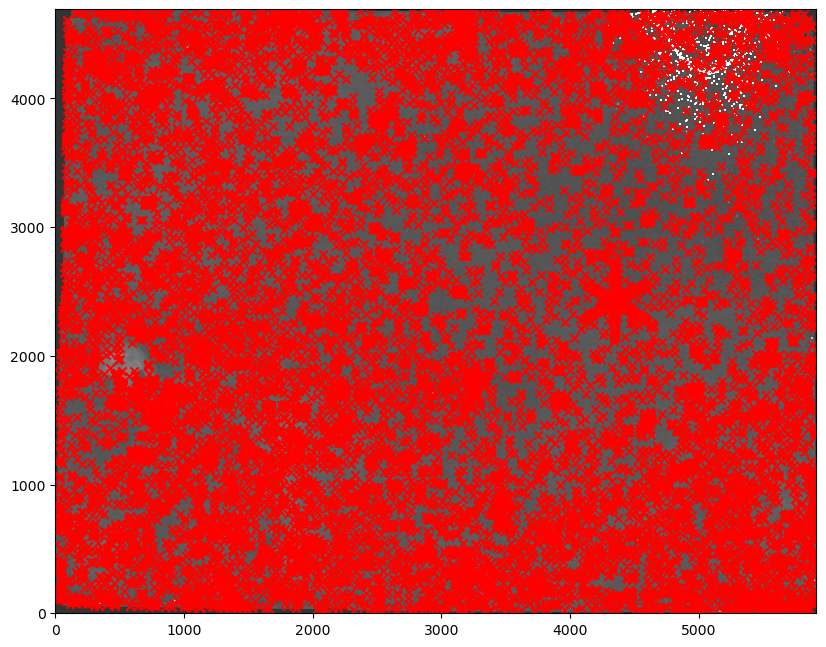

In [11]:
pl.imshow(data, norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(stars_paa['xcentroid'], stars_paa['ycentroid'], marker='x', color='r')

In [12]:
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel

In [13]:
def kill_star(cutout, radius, kernelwidth=1, nanneg=False, zeroneg=True):
    #print(cutout.size)
    cutoutcopy = cutout.copy()
    #print(cutoutcopy.size)
    yy, xx = np.indices(cutout.shape)
    #print("yy")
    rr2 = (xx - cutout.shape[1]/2)**2 + (yy - cutout.shape[0]/2)**2
    #print("rr2")
    msk = rr2 < radius**2
    # ignore negatives
    if nanneg:
        msk[cutoutcopy < 0] = np.nan
    #print('msksum: ',msk.sum())
    cutoutcopy[msk] = np.nan
    sm = convolve(cutoutcopy, Gaussian2DKernel(kernelwidth))
    sm[sm < 0] = 0
    cutoutcopy[msk] = sm[msk]
    return cutoutcopy

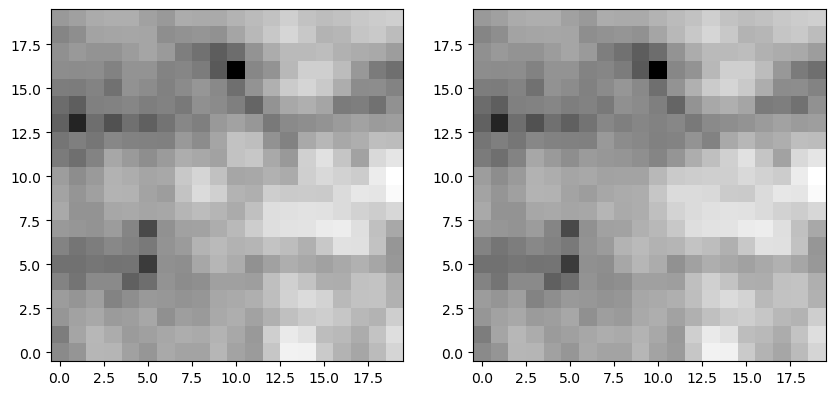

In [14]:
row = stars_paa[350]
sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
co = data[sy-10:sy+10, sx-10:sx+10]
pl.subplot(1,2,1).imshow(co, norm=simple_norm(co, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(kill_star(co, 3.5), norm=simple_norm(co, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')

In [15]:
from tqdm.notebook import tqdm

In [16]:
#datacopy = data.copy()

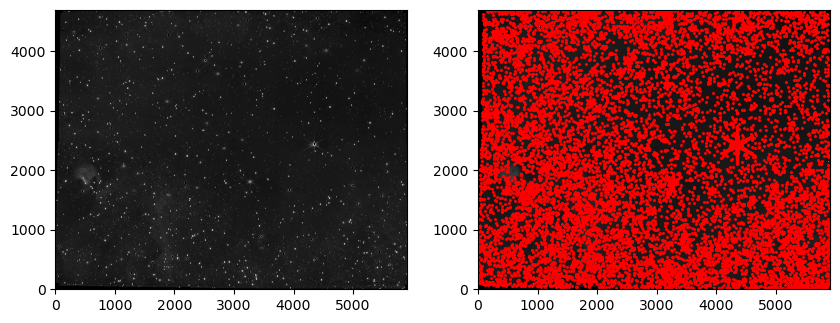

In [17]:
pl.subplot(1,2,1).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=1.1, max_percent=99.995, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=1.1, max_percent=99.995, stretch='log'), cmap='gray')
pl.scatter(stars_paa['xcentroid'], stars_paa['ycentroid'], marker='x', color='r', s=2)

## Replace NaNs by interpolating

In [18]:
print(np.isnan(data).sum())
for sy, sx in tqdm(zip(*np.where(np.isnan(data)))):
    if sx > 5 and sy > 5 and sy < data.shape[0] - 5 and sx < data.shape[1] - 5:
        co = data[sy-5:sy+5, sx-5:sx+5]
        #print(np.isnan(co)).sum()
        data[sy-5:sy+5, sx-5:sx+5] = kill_star(co, 1)
        #print(np.isnan(data[sy-5:sy+5, sx-5:sx+5]).sum())
print(np.isnan(data).sum())

947


0it [00:00, ?it/s]

16


In [19]:
for row in tqdm(stars_paa):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 4.5)

  0%|          | 0/18591 [00:00<?, ?it/s]

In [20]:
np.isnan(data).sum()

16

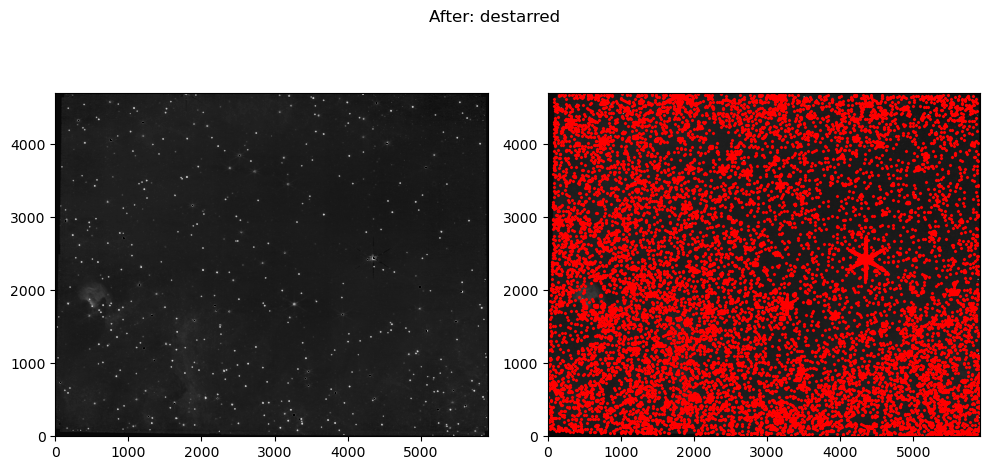

In [21]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.995, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.995, stretch='log'), cmap='gray')
pl.scatter(stars_paa['xcentroid'], stars_paa['ycentroid'], marker='x', color='r', s=2)
pl.suptitle("After: destarred");
pl.tight_layout();

In [22]:
header = fits.getheader(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred.fits', overwrite=True)

In [23]:
fh_182 = fits.open(f'{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca_i2d.fits')
stars_182 = DAOStarFinder(threshold=150, fwhm=2.06, peakmax=1000)(fh_182['SCI'].data)
len(stars_182)

7836

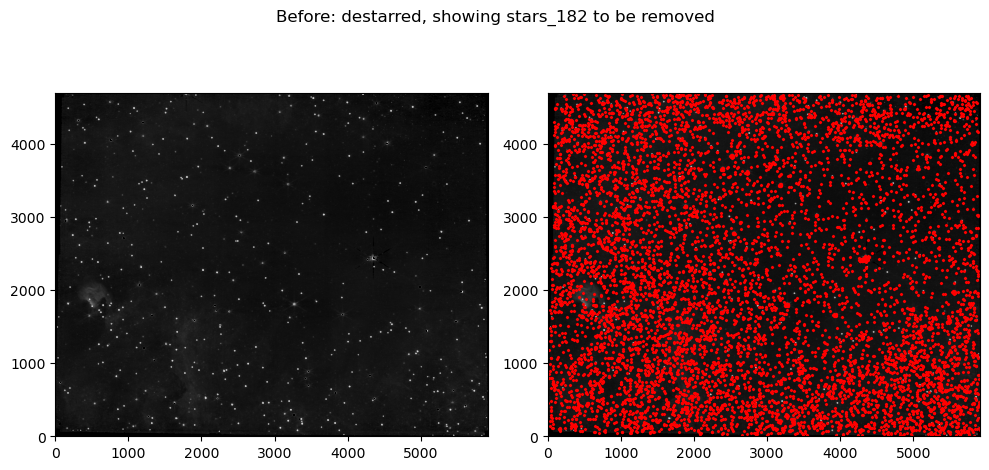

In [24]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.995, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.995, stretch='log'), cmap='gray')
pl.scatter(stars_182['xcentroid'], stars_182['ycentroid'], marker='x', color='r', s=2)
pl.suptitle("Before: destarred, showing stars_182 to be removed");
pl.tight_layout()

In [25]:
for row in tqdm(stars_182):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 5.5, 1.5)

  0%|          | 0/7836 [00:00<?, ?it/s]

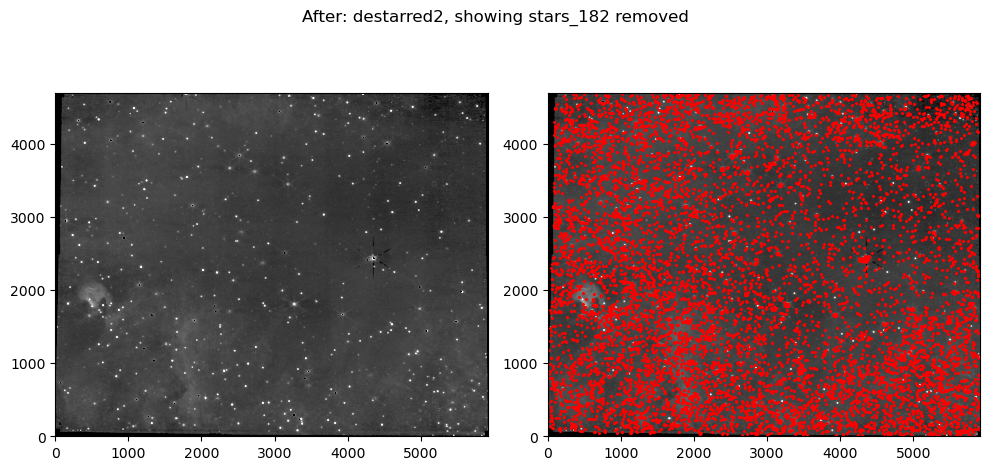

In [26]:
pl.figure(figsize=(10,5))
#pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,1).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(stars_182['xcentroid'], stars_182['ycentroid'], marker='x', color='r', s=2)
pl.suptitle("After: destarred2, showing stars_182 removed");
pl.tight_layout();

In [27]:
header = fits.getheader(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred2.fits', overwrite=True)

In [28]:
fh_187 = fits.open(f'{basepath}/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca_i2d.fits')
stars_paa_br = DAOStarFinder(threshold=1000, fwhm=2.06, peakmax=7e5)(fh_187['SCI'].data)
len(stars_paa_br)

3062

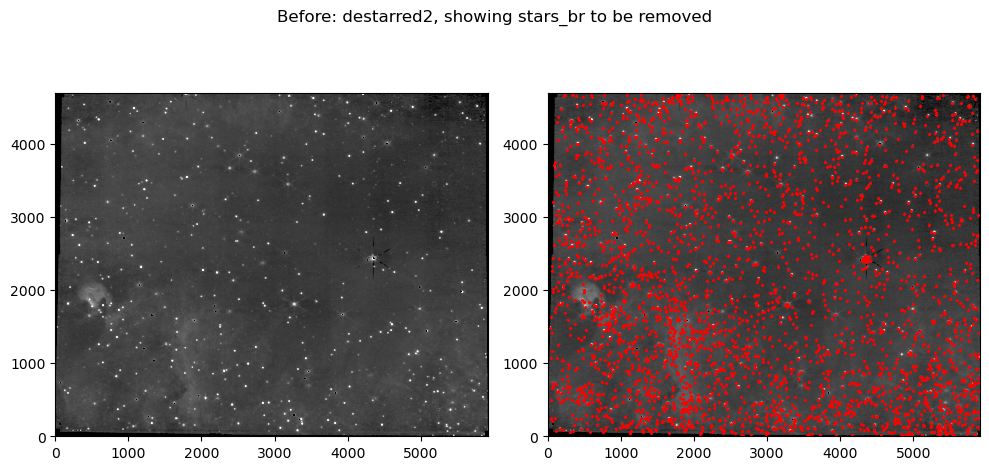

In [29]:
pl.figure(figsize=(10,5))
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,1).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(stars_paa_br['xcentroid'], stars_paa_br['ycentroid'], marker='x', color='r', s=2)
pl.suptitle("Before: destarred2, showing stars_br to be removed");
pl.tight_layout();

In [30]:
for row in tqdm(stars_paa_br):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 15 and sy > 15 and sy < data.shape[0] - 15 and sx < data.shape[1] - 15:
        co = data[sy-15:sy+15, sx-15:sx+15]
        data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 7.5, 2)

  0%|          | 0/3062 [00:00<?, ?it/s]

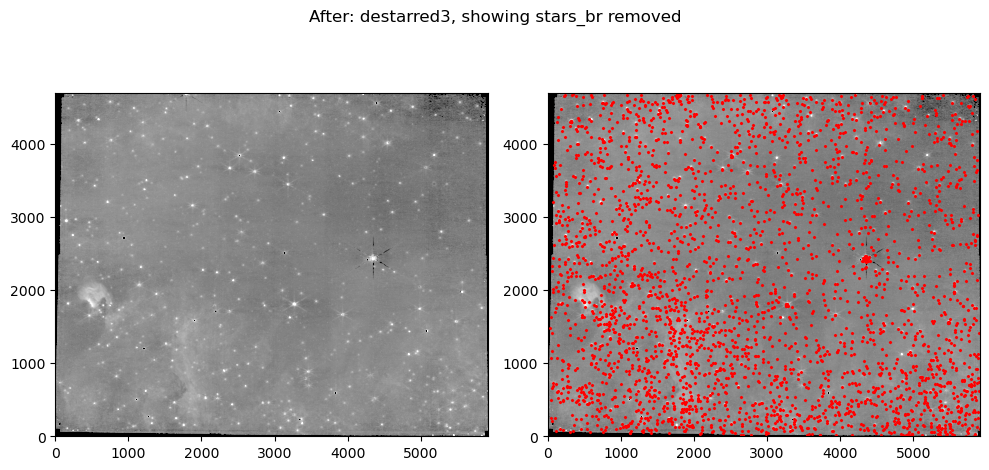

In [31]:
pl.figure(figsize=(10,5))
#pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,1).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(stars_paa_br['xcentroid'], stars_paa_br['ycentroid'], marker='x', color='r', s=2)
pl.suptitle("After: destarred3, showing stars_br removed");
pl.tight_layout();

In [32]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred3.fits', overwrite=True)

In [33]:
data = fits.getdata(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred3.fits')

In [34]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(data, 30, npixels=5)

In [35]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segment_map)
cattbl = cat.to_table()

In [36]:
cat.area

<Quantity [131.,  27., 178., ...,   5.,   5.,   8.] pix2>

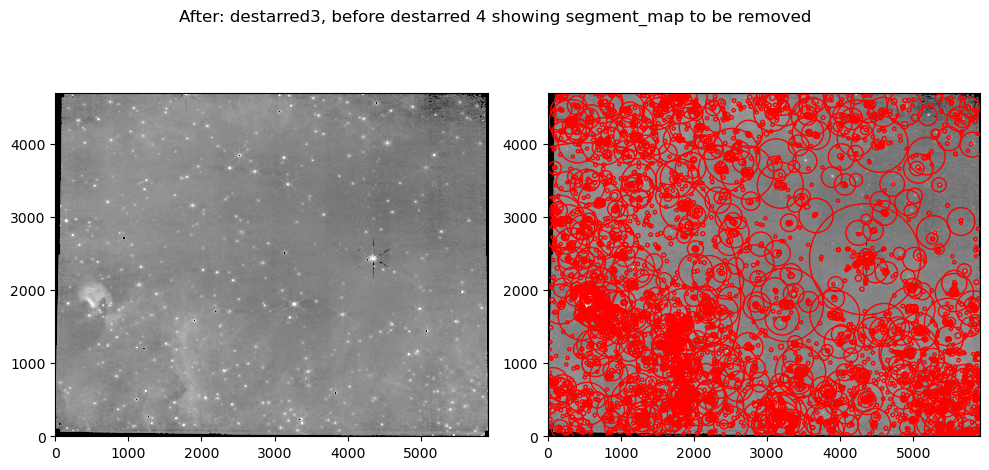

In [37]:
pl.figure(figsize=(10,5))
#pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,1).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(cattbl['xcentroid'], cattbl['ycentroid'], marker='o', color='r', facecolor='none', s=cat.area)
pl.suptitle("After: destarred3, before destarred 4 showing segment_map to be removed");
pl.tight_layout();

In [38]:
# this is the extended HII region in nrca xk,yk = 208,782
for row in tqdm(cat):
    
    if row.area.value > 1000: 
        print(f"Skipping {row}, {row.centroid}")
        continue
    if True: #xk < row.bbox.ixmin or xk > row.bbox.ixmax or yk < row.bbox.iymin or yk > row.bbox.ixmax:
        sx,sy = map(int, (row.centroid))
        dx = 30 if row.area.value < 75 else 40
        rad_excise = 15 if row.area.value < 75 else 20
        rad_kernel = 3 if row.area.value < 75 else 5
        if sx > dx and sy > dx and sy < data.shape[0] - dx and sx < data.shape[1] - dx:
            co = data[sy-dx:sy+dx, sx-dx:sx+dx]
            data[sy-dx:sy+dx, sx-dx:sx+dx] = kill_star(co, rad_excise, rad_kernel)
    else:
        print(f"Skipped {row} -> {row.centroid}")

  0%|          | 0/5003 [00:00<?, ?it/s]

Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [196], [5349.59121473  141.23439788]
Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [205], [1757.1185417   150.35287507]
Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [241], [3370.11071     195.37965418]
Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [586], [5400.81739003  360.3797489 ]
Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [673], [5601.97190217  407.09386775]
Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [885], [2055.63853255  520.1445632 ]
Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [970], [1962.86201055  549.18897815]
Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [1183], [5723.52509777  620.9139202 ]
Skipping <photutils.segmentation.catalog.SourceCatalog>
Length: 1
labels: [1597], [3457.66163736  879.15823537]

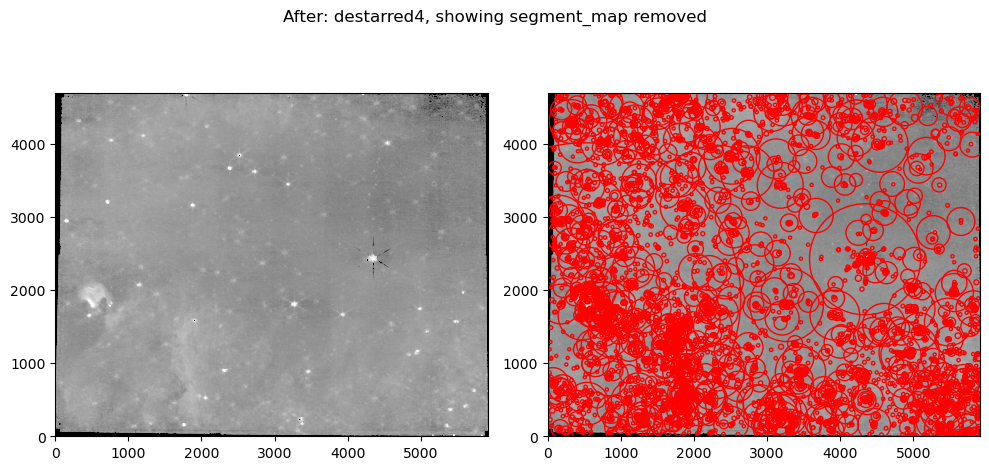

In [39]:
pl.figure(figsize=(10,5))
#pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=0.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,1).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.subplot(1,2,2).imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3.1, max_percent=99.95, stretch='log'), cmap='gray')
pl.scatter(cattbl['xcentroid'], cattbl['ycentroid'], marker='o', color='r', facecolor='none', s=cat.area)
pl.suptitle("After: destarred4, showing segment_map removed");
pl.tight_layout();

In [40]:
import regions
# TODOD regs = regions.Regions.read(f'{basepath}/regions/manual_destar_right_187.reg')


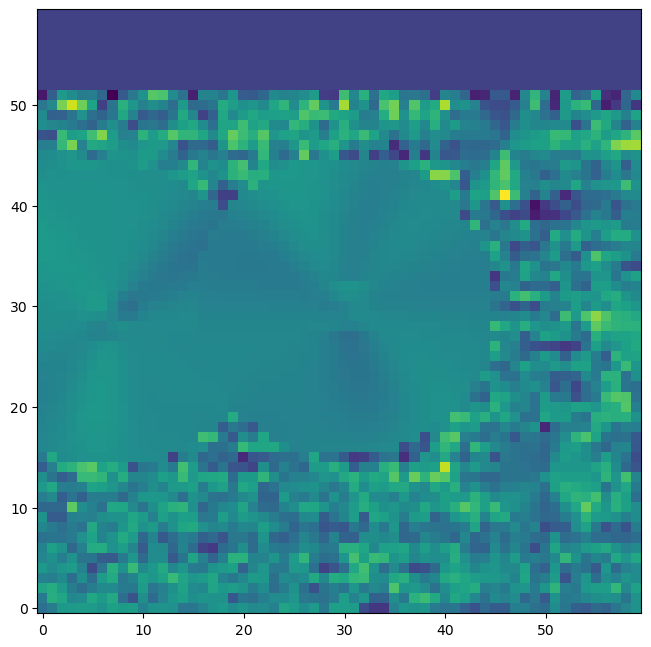

In [41]:
pl.imshow(co)

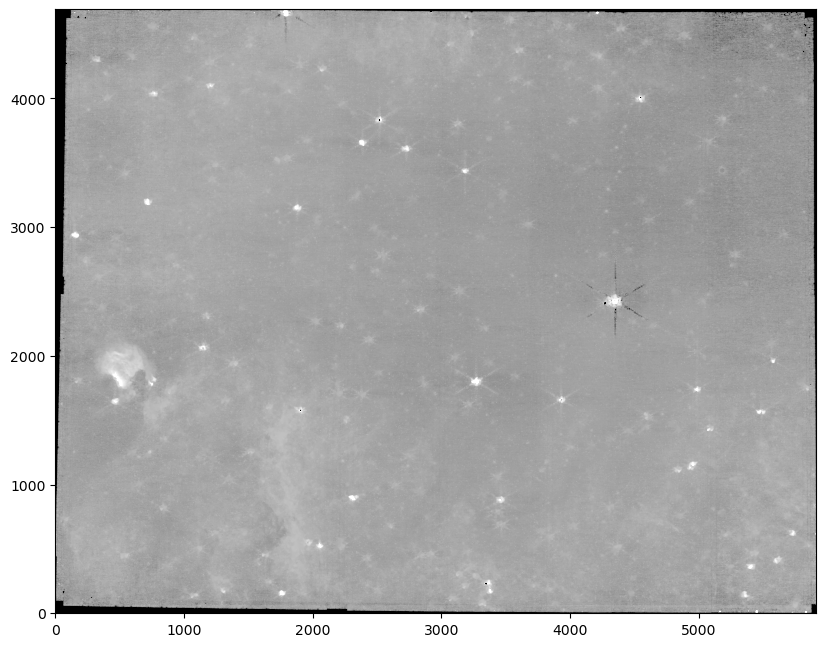

In [42]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_paa['xcentroid'], stars_paa['ycentroid'], marker='x', color='r')

In [43]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred4.fits', overwrite=True)

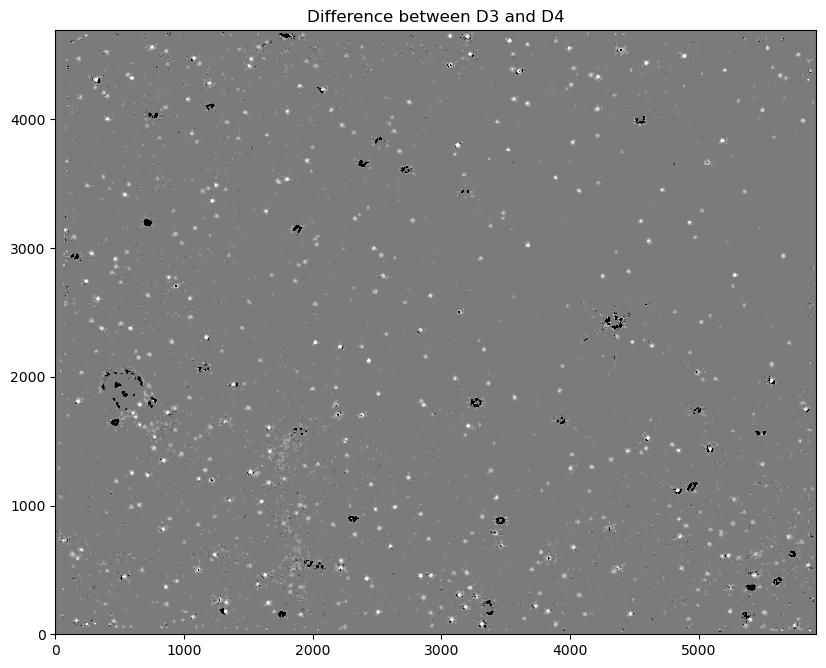

In [44]:
d3 = fits.getdata(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred3.fits')
d4 = fits.getdata(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred4.fits')
pl.imshow(np.nan_to_num(d3-d4), norm=simple_norm(d3-d4, min_percent=1, max_percent=99.95, stretch='log'), cmap='gray')
pl.title("Difference between D3 and D4");

In [45]:
data = fits.getdata(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred4.fits')

In [46]:
fh_182 = fits.open(f'{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca_i2d.fits')
stars_182_f = DAOStarFinder(threshold=25, fwhm=2.06, peakmax=150)(fh_182['SCI'].data)
len(stars_182_f)

37317

In [47]:
for row in tqdm(stars_182_f):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

  0%|          | 0/37317 [00:00<?, ?it/s]

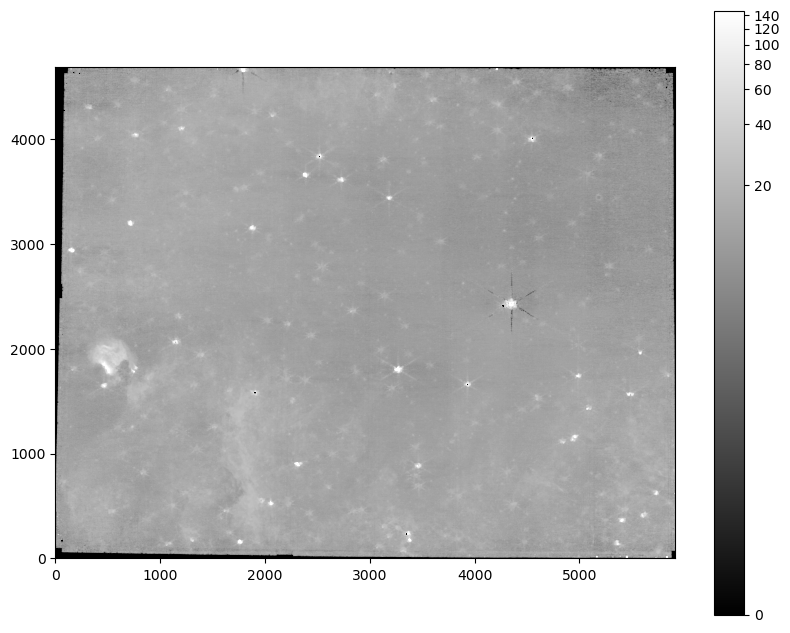

In [48]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=1, max_percent=99.95, stretch='log'), cmap='gray')
#pl.scatter(stars_paa['xcentroid'], stars_paa['ycentroid'], marker='x', color='r')
pl.colorbar();

In [49]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred5.fits', overwrite=True)

In [50]:
data = fits.getdata(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred5.fits')

In [51]:
# Saturated in f182
stars_paa_sat182 = DAOStarFinder(threshold=500, fwhm=2.06, peakmax=3000)(fh_187['SCI'].data)
len(stars_paa_sat182)

4087

In [52]:
for row in tqdm(stars_paa_sat182):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 15 and sy > 15 and sy < data.shape[0] - 15 and sx < data.shape[1] - 15:
        co = data[sy-15:sy+15, sx-15:sx+15]
        data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 5.5, 2)

  0%|          | 0/4087 [00:00<?, ?it/s]

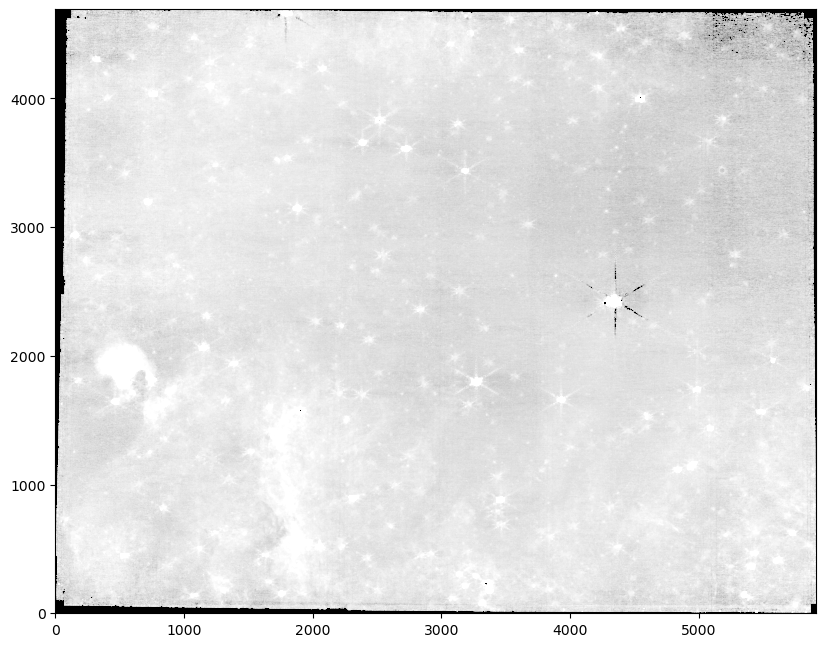

In [53]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3, max_percent=98., stretch='log'), cmap='gray')
#pl.scatter(stars_paa['xcentroid'], stars_paa['ycentroid'], marker='x', color='r')

In [54]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred6.fits', overwrite=True)

# Do it again for f212

In [55]:
data = fits.getdata(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca.fits')
np.isnan(data).sum()

FileNotFoundError: [Errno 2] No such file or directory: '/orange/adamginsburg/jwst/brick//images/F212_minus_F182cont_refitted212wcsto182_nrca.fits'

In [ ]:
print(np.isnan(data).sum())
for sy, sx in tqdm(zip(*np.where(np.isnan(data)))):
    if sx > 5 and sy > 5 and sy < data.shape[0] - 5 and sx < data.shape[1] - 5:
        co = data[sy-5:sy+5, sx-5:sx+5]
        #print(np.isnan(co)).sum()
        data[sy-5:sy+5, sx-5:sx+5] = kill_star(co, 1)
        #print(np.isnan(data[sy-5:sy+5, sx-5:sx+5]).sum())
print(np.isnan(data).sum())
assert not np.isnan(data[1054,645]) #this check is for BrA...

In [ ]:
data[data<0] = 0

In [ ]:
stars_212 = DAOStarFinder(threshold=30, fwhm=2.341, peakmax=1e4)(data)
len(stars_212)

In [ ]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3, max_percent=95., stretch='log'), cmap='gray')
pl.scatter(stars_212['xcentroid'], stars_212['ycentroid'], marker='o', color='r', edgecolor='r', facecolor='none')

In [ ]:
for row in tqdm(stars_paa):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

In [ ]:
header = fits.getheader(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred.fits', overwrite=True)

In [ ]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3, max_percent=95., stretch='log'), cmap='gray')
#pl.scatter(stars_paa['xcentroid'], stars_paa['ycentroid'], marker='x', color='r')

In [ ]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3, max_percent=95., stretch='log'), cmap='gray')
pl.scatter(stars_182['xcentroid'], stars_182['ycentroid'], marker='o', color='b', edgecolor='b', facecolor='none')

In [ ]:
for row in tqdm(stars_182):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 5.5, 1.5)

In [ ]:
header = fits.getheader(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca.fits')
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred2.fits', overwrite=True)

In [ ]:
fh_212 = fits.open(f'{basepath}/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca_i2d.fits')
stars_212_br = DAOStarFinder(threshold=2000, fwhm=2.341, peakmax=3e4)(fh_212['SCI'].data)
len(stars_212_br)

In [ ]:
data = fits.getdata(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred2.fits')

In [ ]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3, max_percent=95., stretch='log'), cmap='gray')
pl.scatter(stars_212_br['xcentroid'], stars_212_br['ycentroid'], marker='x', color='g', edgecolor='g', facecolor='g')

In [ ]:
for row in tqdm(stars_212_br):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 30 and sy > 30 and sy < data.shape[0] - 30 and sx < data.shape[1] - 30:
        #co = data[sy-15:sy+15, sx-15:sx+15]
        #data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 7.5, 2)
        co = data[sy-30:sy+30, sx-30:sx+30]
        data[sy-30:sy+30, sx-30:sx+30] = kill_star(co, 15, 5)

In [ ]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred3.fits', overwrite=True)

In [ ]:
data = fits.getdata(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred3.fits')

In [ ]:
from photutils.segmentation import detect_sources
segment_map = detect_sources(data, 100, npixels=5)

In [ ]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(data, segment_map)
cattbl = cat.to_table()

In [ ]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3, max_percent=95., stretch='log'), cmap='gray')
pl.scatter(cat.xcentroid, cat.ycentroid, marker='x', color='r', edgecolor='r', facecolor='r')

In [ ]:
# pixel coordinate of bright extended emission
xk,yk = 208,782

In [ ]:
for row in tqdm(cat):
    if row.area.value > 1000: 
        print(f"Skipping {row}, {row.centroid}")
        continue
    if xk < row.bbox.ixmin or xk > row.bbox.ixmax or yk < row.bbox.iymin or yk > row.bbox.ixmax:
        sx,sy = map(int, (row.centroid))
        dx = 30 if row.area.value < 75 else 40
        rad_excise = 15 if row.area.value < 75 else 20
        rad_kernel = 3 if row.area.value < 75 else 5
        if sx > dx and sy > dx and sy < data.shape[0] - dx and sx < data.shape[1] - dx:
            co = data[sy-dx:sy+dx, sx-dx:sx+dx]
            data[sy-dx:sy+dx, sx-dx:sx+dx] = kill_star(co, rad_excise, rad_kernel)
    else:
        print(f"Skipped {row} -> {row.centroid}")

In [ ]:
import regions
regs = regions.Regions.read(f'{basepath}/regions/manual_destar_right_212.reg')

In [ ]:
for reg in tqdm(regs):
    preg = reg.to_pixel(ww)
    mask = preg.to_mask()
    bbox = mask.bbox
    dx = 20
    bbox.ixmin -= dx
    bbox.iymin -= dx
    bbox.ixmax += dx
    bbox.iymax += dx
    co = data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax].copy()
    co[dx:-dx, dx:-dx][mask.data.astype('bool')] = np.nan
    msk = np.isnan(co)
    sm = convolve(co, Gaussian2DKernel(10))
    #sm[sm < 0] = 0
    co[msk] = sm[msk]
    data[bbox.iymin:bbox.iymax, bbox.ixmin:bbox.ixmax] = co

In [ ]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred4.fits', overwrite=True)

In [ ]:
data = fits.getdata(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred4.fits')

In [ ]:
pl.imshow(np.nan_to_num(data), norm=simple_norm(data, min_percent=3, max_percent=95., stretch='log'), cmap='gray')
pl.scatter(stars_182_f['xcentroid'], stars_182_f['ycentroid'], marker='o', color='c', edgecolor='c', facecolor='none')

In [ ]:
for row in tqdm(stars_182_f):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 10 and sy > 10 and sy < data.shape[0] - 10 and sx < data.shape[1] - 10:
        co = data[sy-10:sy+10, sx-10:sx+10]
        data[sy-10:sy+10, sx-10:sx+10] = kill_star(co, 3.5)

In [ ]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred5.fits', overwrite=True)

In [ ]:
data = fits.getdata(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred5.fits')

In [ ]:
# Saturated in f182
stars_212_sat182 = DAOStarFinder(threshold=500, fwhm=2.341, peakmax=3000)(fh_212['SCI'].data)
len(stars_212_sat182)

In [ ]:
for row in tqdm(stars_212_sat182):
    sx,sy = map(int, (row['xcentroid'], row['ycentroid']))
    if sx > 15 and sy > 15 and sy < data.shape[0] - 15 and sx < data.shape[1] - 15:
        co = data[sy-15:sy+15, sx-15:sx+15]
        data[sy-15:sy+15, sx-15:sx+15] = kill_star(co, 5.5, 2)

In [ ]:
fits.PrimaryHDU(data=data, header=header).writeto(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred6.fits', overwrite=True)

In [ ]:
import pyavm
import PIL
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [ ]:
rgb = np.array(
      [
       #fits.getdata(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca.fits'),
       #fits.getdata(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca.fits'),
       fits.getdata(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrca_destarred6.fits'),
       fits.getdata(f'{basepath}/images/F187_minus_F182cont_refitted187wcsto182_nrca_destarred6.fits'),
       fits.getdata(f'{basepath}/images/F182_minus_F187_nrca.fits')
      ]
).swapaxes(0,2).swapaxes(0,1)
#for layer in (0,1,2):
#    # desaturate stars (though this will whiten the edges!)
#    rgb[:,:,layer][np.isnan(rgb[:,:,layer])] = np.nanmax(rgb[:,:,layer])
#    rgb[:,:,layer][rgb[:,:,layer] == 0] = np.nanmax(rgb[:,:,layer])

In [ ]:
AVM = pyavm.AVM.from_header(fits.getheader(f'{basepath}/images/F182_minus_F187_nrca.fits'))
# AVM = pyavm.AVM.from_header(fits.getheader(f'{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca_i2d.fits', ext=['SCI', 1]))

In [ ]:
def save_rgb(img, filename):
    img = (img*256)
    img[img<0] = 0
    img[img>255] = 255
    img = img.astype('uint8')
    img = PIL.Image.fromarray(img[::-1,:,:])
    img.save(filename)

In [ ]:
narrowsum = rgb[:,:,0] + rgb[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-1, max_cut=90)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-1, max_cut=120)(rgb[:,:,1]),
                       simple_norm(narrowsum,  stretch='asinh', min_cut=-2, max_cut=210)(narrowsum)]).swapaxes(0,2).swapaxes(0,1)
hsv = rgb_to_hsv(rgb_scaled)
hsv[:,:,0] += -0.35  # 0.25 = 90/360
hsv[:,:,0] = hsv[:,:,0] % 1 
rgb_scaled = hsv_to_rgb(hsv)
pl.figure(figsize=(24,10))
pl.imshow(rgb_scaled, origin='lower')
pl.xticks([]);
pl.yticks([]);

outfn = f"{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated.png"
save_rgb(rgb_scaled, outfn)
AVM.embed(outfn, outfn)

In [ ]:
narrowsum = rgb[:,:,0] + rgb[:,:,1]
rgb_scaled = np.array([
                       simple_norm(rgb[:,:,0], stretch='asinh', min_cut=-2, max_cut=70)(rgb[:,:,0]),
                       simple_norm(rgb[:,:,1], stretch='asinh', min_cut=-2, max_cut=100)(rgb[:,:,1]),
                       simple_norm(narrowsum,  stretch='asinh', min_cut=-4, max_cut=170)(narrowsum)]).swapaxes(0,2).swapaxes(0,1)
hsv = rgb_to_hsv(rgb_scaled)
hsv[:,:,0] += -0.35  # 0.25 = 90/360
hsv[:,:,0] = hsv[:,:,0] % 1 
rgb_scaled = hsv_to_rgb(hsv)
pl.figure(figsize=(24,10))
pl.imshow(rgb_scaled, origin='lower')
pl.xticks([]);
pl.yticks([]);

outfn = f"{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png"
save_rgb(rgb_scaled, outfn)
AVM.embed(outfn, outfn)

In [ ]:
PIL.Image.open(outfn)